In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on lattice (the original DGMRFs on images)

Original code can be found [here](https://bitbucket.org/psiden/deepgmrf/src/master/main_script.py). And the article is [here](http://proceedings.mlr.press/v119/siden20a/siden20a.pdf).

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [4]:
H = 70
W = 70
r = 10

In [5]:
from dgmrf.utils import cholesky_sampling_gaussian_field
key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

In [6]:
x_stripes = jnp.ones_like(x_ori)
x_stripes = x_stripes.at[10:15, 10:40].set(0)
x_stripes = x_stripes.at[20:25, 10:40].set(0)
x_stripes = x_stripes.at[30:35, 10:40].set(0)
x_stripes = x_stripes.at[40:45, 10:40].set(0)
x_stripes = x_stripes.at[10:60, 50:55].set(0)
x_stripes = x_stripes.at[10:60, 60:65].set(0)

x_ori += x_stripes

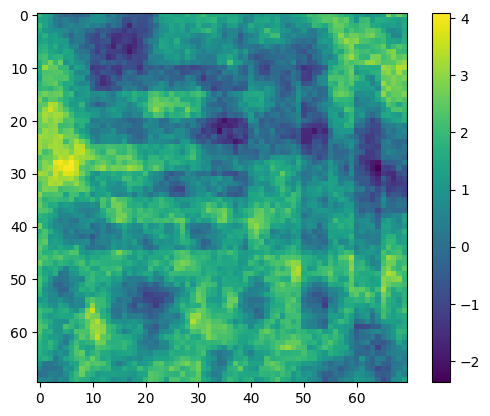

In [7]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [8]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.01
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
#y = jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
N = H * W

In [9]:
#y = jnp.pad(y, 10)

In [10]:
mask = jnp.zeros_like(y)

# As advised by the article to avoid border effects
# mask = mask.at[:10, :].set(1)
# mask = mask.at[-10:, :].set(1)
# mask = mask.at[:, -10:].set(1)
# mask = mask.at[:, :10].set(1)
# H += 20
# W += 20
# N = H * W

mask = mask.at[20:60, 30:40].set(1)

y = jnp.where(mask == 0, y, 0)

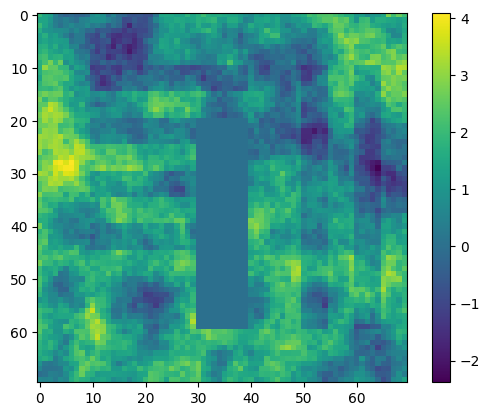

In [11]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF
In the supplementary material of Siden 2020 they claim that the biases are fixed to 0.

In [12]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_adjacency_matrix_lattice

In [13]:
L = 3
Nq = 10

In [14]:
y = y.flatten()
mask = mask.flatten()

**Note** it seems that inpainting is better achieved when setting `with_bias=False`. This is also what is proposed in the Appendix paper of Sidén 2020

In [15]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(subkey, L, height_width=(H, W), with_bias=False)
dgmrf_params, dgmrf_static = eqx.partition(dgmrf, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!

Instanciate the variational distribution we can choose between **Mean-Field** variational distribution and the **factorized distribution** proposed by Oskarsson. While the latter gives slightly better results it is much slower.

In [16]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=H * W, key=subkey)
#q_phi = FactorizedS(N=H * W, dgmrf_args=(subkey1, 1), dgmrf_kwargs={"height_width":(H, W), "with_bias":False}, key=subkey2)
q_phi_params, q_phi_static = eqx.partition(q_phi, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!

## Variational inference to compute model parameters

The initial values of the mean and std for the variational distribution are given lines 572 and 573 of the orignal code.

In [17]:
key, subkey1, subkey2 = jax.random.split(key, 3)
params_init = {
    "dgmrf":dgmrf_params,
    "q_phi":q_phi_params,
    "log_sigma":jnp.log(true_sigma_noise),
}
static = {
    "dgmrf": dgmrf_static,
    "q_phi": q_phi_static
}


In [18]:
n_iter = 1000
lr_conv = 1e-2

lr = lr_conv
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    {'dgmrf':"dgmrf", 'log_sigma':'log_sigma', 'q_phi':'q_phi'} # This what would be returned by the label_fn; i.e. this is the correct syntax when directly giving labels and when params is dict
)
opt_state = tx.init(params_init)

In [19]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

key, subkey = jax.random.split(key, 2)
params_final, loss_val = train_loop(dgmrf_elbo, y, n_iter, params_init, static, tx, opt_state, subkey, N, Nq, mask)

  0%|          | 0/1000 [00:00<?, ?it/s]

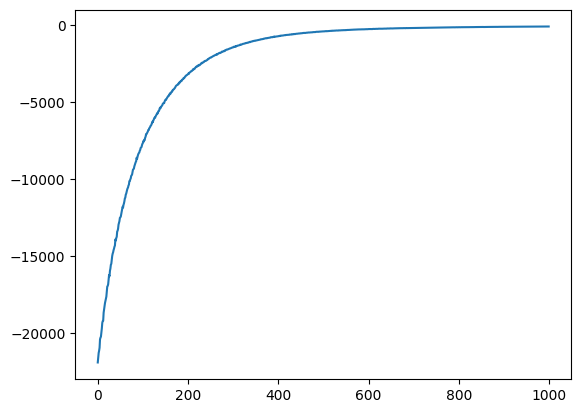

In [20]:
plt.plot(-loss_val)
plt.show()

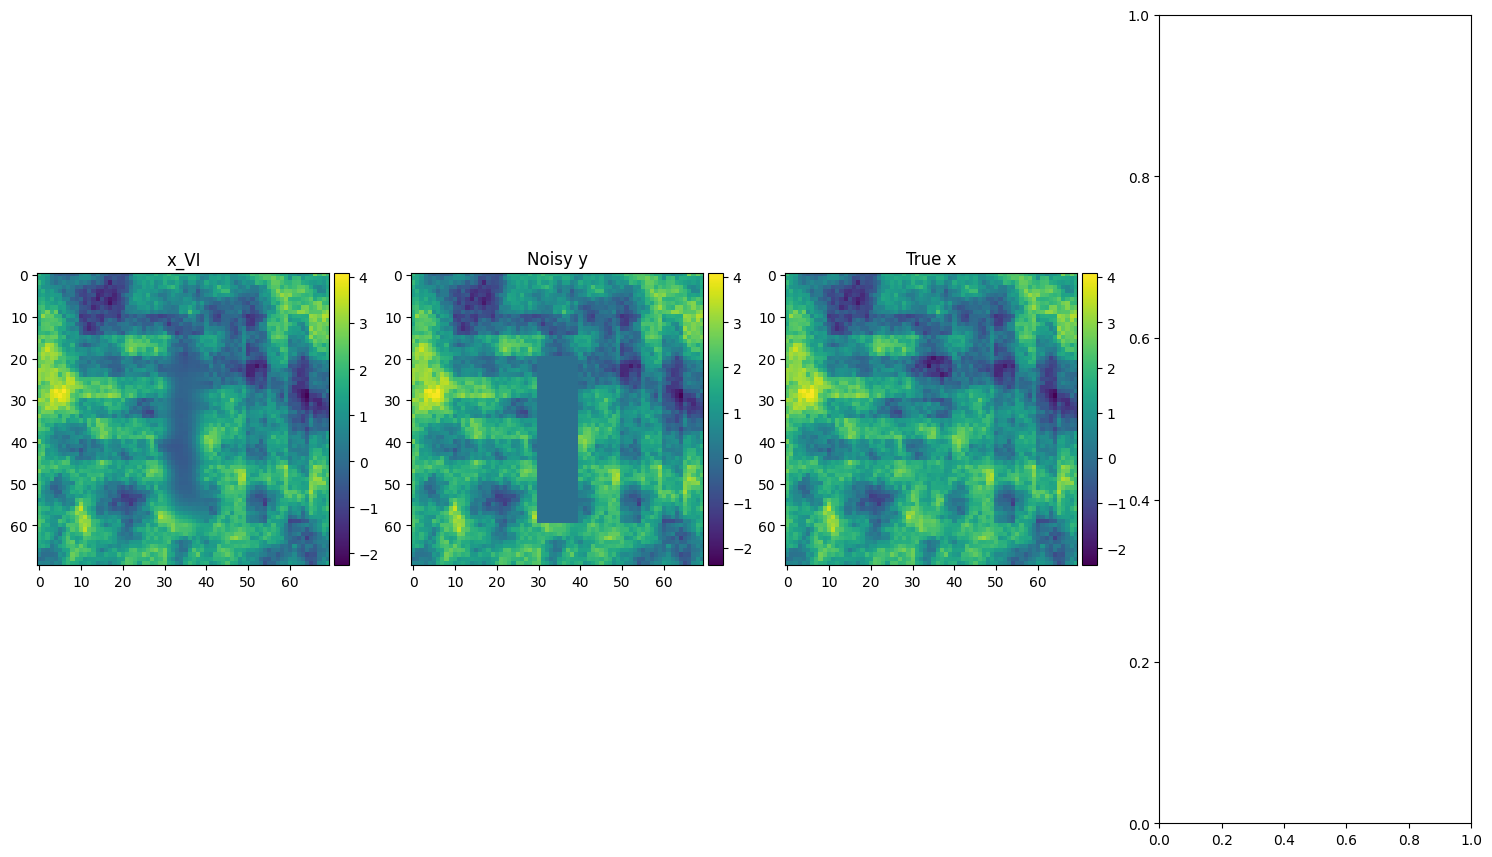

In [21]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(params_final["q_phi"].params["nu"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# im = axes[3].imshow(jnp.abs(params_final["nu_phi"].reshape(H, W) - x_ori))
# divider = make_axes_locatable(axes[3])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
# axes[3].set_title("|x_VI - x|")

plt.show()

## Analyze the filters

Params for layer l=0 [ 1.4369905  -0.25885457 -0.84128124 -0.12407304 -0.16761853  0.10309774
  0.70252734]
Params for layer l=1 [1.3431427  0.28541988 0.24390942 0.28161567 0.23009484 0.15125184
 0.80922496]
Params for layer l=2 [ 1.5652201  -0.12063701 -0.11825103 -0.86553323 -0.06576275 -0.01467885
  0.7155121 ]


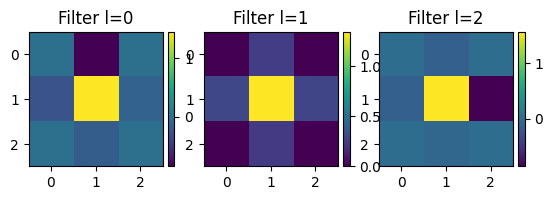

In [22]:
from dgmrf.layers import ConvLayer
fig.set_size_inches(30.5, 15.5)

fig, axes = plt.subplots(1, L + 1 if L == 1 else L)
for l in range(L):
    f1_ = ConvLayer.params_transform(params_final["dgmrf"].layers[l].params)
    print(f"Params for layer {l=}", ConvLayer.params_transform(params_final["dgmrf"].layers[l].params))
    f1 = jnp.array([[0, f1_[2], 0], [f1_[1], f1_[0], f1_[3]], [0, f1_[4], 0]])
    im = axes[l].imshow(f1)
    axes[l].set_title(f"Filter {l=}")
    divider = make_axes_locatable(axes[l])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## Posterior mean computation with conjugate gradient

In [23]:
dgmrf = eqx.combine(params_final["dgmrf"], static["dgmrf"])

The next cell should output something more or less like the realization of the standard normal

[]

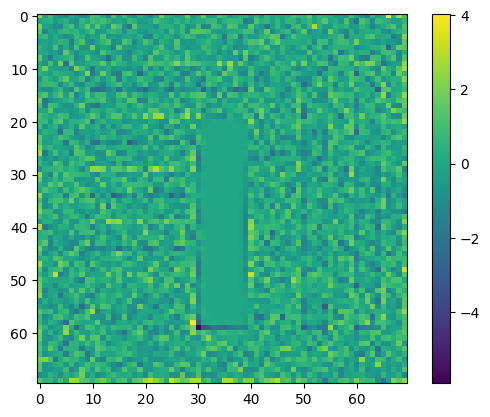

In [24]:
z = dgmrf(y)
plt.imshow(z.reshape((H, W)))
plt.colorbar()
plt.plot()

**Note**, on this example, we can still afford the computation of exactly inverting $\tilde{Q}$ to compute exactly the posterior mean without the conjugate gradient:

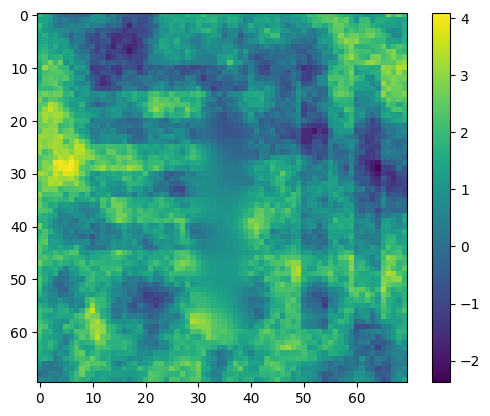

In [25]:
mu_post_exact = dgmrf.get_post_mu(
    y,
    params_final["log_sigma"],
    mask=mask,
    method="exact"
)
plt.imshow(mu_post_exact.reshape((H, W)))
plt.colorbar()
plt.show()

But we can also compute the posterior mean with approximate inversion of $\tilde{Q}$ using conjugate gradient. **Note that this approach seems very unstable as soon as we add more noise than that of the context of the article (Siden 2020) ($\sigma > 0.01$) or when L > 3.** One would need to upgrade to more robust CG algorithms.

In [26]:
mu_post_cg = dgmrf.get_post_mu(
    y,
    params_final["log_sigma"],
    mu0=params_final["q_phi"].params["nu"],
    mask=mask,
    method="cg"
)

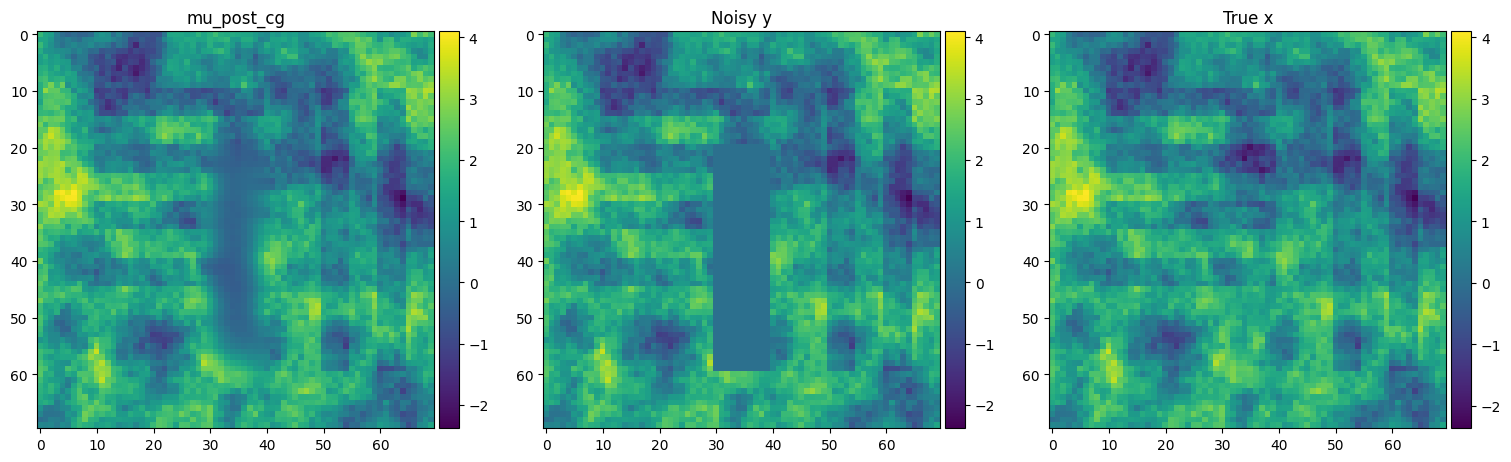

In [27]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(mu_post_cg.reshape(H, W))
axes[0].set_title("mu_post_cg")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Posterior samples to compute the posterior marginal variances

In [28]:
nb_samples = 50

dgmrf = eqx.combine(params_final["dgmrf"], static["dgmrf"])

key, subkey = jax.random.split(key, 2)
x_post_samples = dgmrf.posterior_samples(nb_samples, params_final["q_phi"].params["nu"], params_final["log_sigma"], subkey, mask=mask, x0=mu_post_cg)

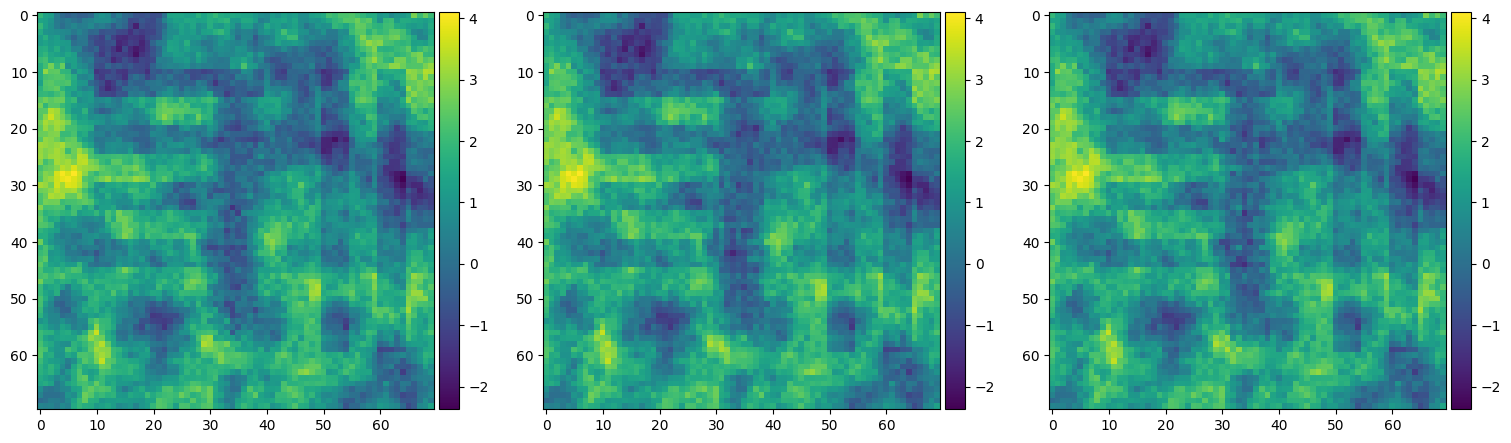

In [29]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

The masked areas are excluded from the computation of the variances

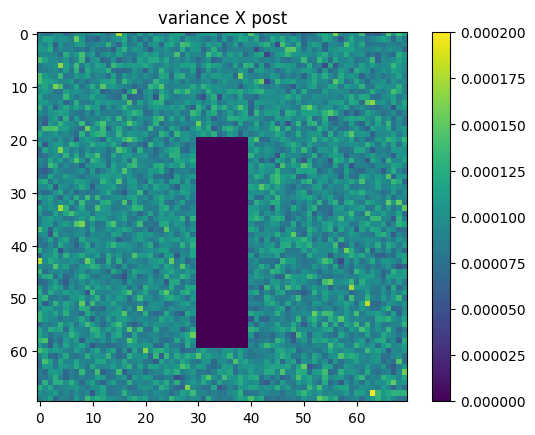

In [30]:
var_x_post_samples = jnp.var(jnp.stack([jnp.where(mask==0,x_post,0) for x_post in x_post_samples], axis=0), axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo

In [31]:
var_x_post_samples_RBMC = dgmrf.rbmc_variance(x_post_samples, params_final["log_sigma"], mask=mask)

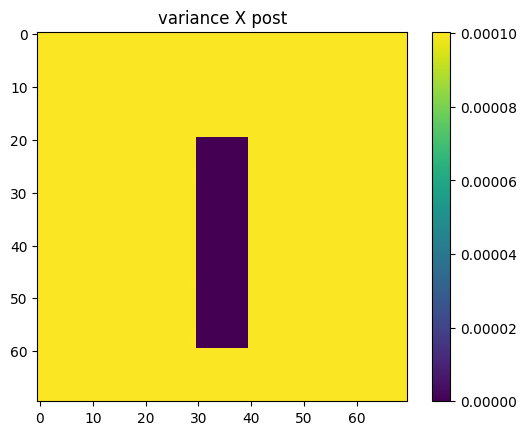

In [32]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()